# Binned likelihood-based forward-folding analysis

In the previous tutorial we learned how to use the detector response matrix to quickly obtain the expected number of counts given a spectral model. Here's a refreseher:

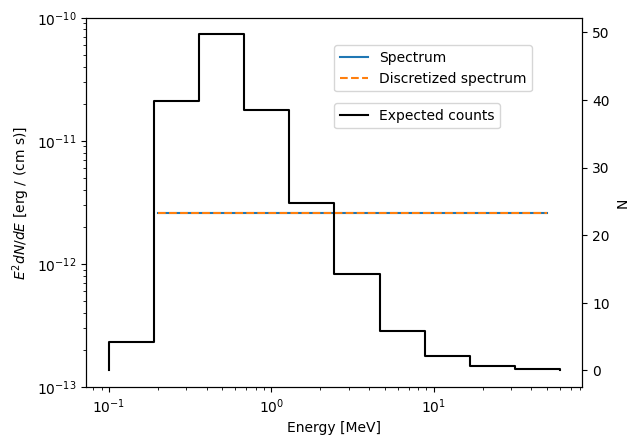

In [61]:
# Imports
from gammaraytoys.detectors import PowerLawSpectrum, PointSource
from gammaraytoys.analysis import SpectralResponse
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from histpy import Histogram
from copy import deepcopy

# Source and observations parameters

duration = 1*u.day
index = -2 
flux_pivot = 1/u.erg/u.cm/u.s
pivot_energy = 1*u.MeV

source = PointSource(offaxis_angle = 0*u.deg,
                     spectrum = PowerLawSpectrum(index = index, 
                                                 min_energy = 200*u.keV,
                                                 max_energy = 50*u.MeV),
                     flux_pivot = flux_pivot,
                     pivot_energy = pivot_energy)

# Convolve the spectral model with the detector response to obtained the expected counts
response = SpectralResponse.open("instrument_response/response_energy_onaxis_traddet.h5")

expected_signal_counts = response.expected_counts(source, duration)

# Get a copy of the data.
# In order to get a sense of what to expect "on average" we'll
# ignore fluctuations for now and will set the data --the arrays 
# of counts on each bin N_k-- exactly to <N_k>
# In the excersize below you'll uncomment the Poisson fluctuations
# and see what happens.

data = deepcopy(expected_signal_counts)
# Uncomment the following line for the excersize
#data[:] = np.random.poisson(data.contents) 

# ==== Plotting ====
fig,axl = plt.subplots()

# Input spectrum. Exact and discretized version
source.plot_spectrum(axl, e2 = True, label = 'Spectrum');
source.plot_spectrum(axl, e2 = True, discretize_axis = response.photon_energy_axis, 
                     label = 'Discretized spectrum', ls = '--');
axl.legend(loc = (.5,.8))

axr = axl.twinx()
data.plot(axr, color = 'black', label = 'Expected counts')
axr.set_ylabel("N")
axr.legend(loc = (.5,.7))

This time we plotted in the y-axis $E^2 F(E)$ instead of just $F(E)$. This is optional and doesn't really change anything in the calculation, but it's an useful and common trick to visualize a spectrum that varies over several order to magnitude. In a  $E^2 F(E)$ plot a spectrum with the same energy flux per decade of energy will look as a horizontal line. This is the same as the $\nu f\nu$ plots commonly used in astronomy. TODO: link to nice paper explaining this.

As we've discussed before, the measured energy distribution looks quite different from the true photon energy distribution due to the energy-dependent effective area and energy dispersion. 

Let's estimate the underlying spectrum using a 0-th order approximation, simply dividing by the effective area, duration and energy bin width. Then we'll fit the resulting data point to power law using a simple chi2 fitting routine.

0-th order chi2 fit
Flux  =  0.64 +- 0.1 [1 / (cm erg s)]
Index = -1.59 +- 0.1


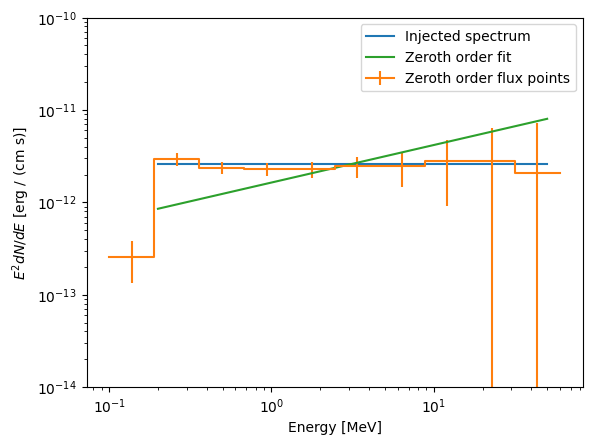

In [3]:
# Start from a copy of the observed counts
# sumw2 stands for the sum of the squared weights. 
# This will allows us to keep track of all operations and propagate 
# the statistical errors from sqrt(N) to the estimated flux
approx_flux = Histogram(data.axis, 
                        data.contents,
                        sumw2 = data.contents)

# Divide by the observed time
approx_flux /= duration 

# Now by the (effective) area
approx_flux /= response.effective_area().interp(data.axis.centers) 

# And finally get the flux *density_ by dividing by the size of the bin
approx_flux /= data.axis.widths # Per energy

# Convert units. Mostly for plotting purposes.
approx_flux = approx_flux.to(u.Unit(1/u.erg/u.cm/u.s), copy = True)

# ==== Fit using chi2 ====
def fun_fit(energy,norm,index):
    """Energy in keV, norm (at 1 MeV) in 1/cm2/s/keV"""
    return norm*energy**index

# This uses scipy's curvefit() method. It returns the fitted optimal parameters and the covariance matrix
popt, pcov = approx_flux.fit(fun_fit)

# The errors on each parameters are, ignoring correlation, the sqrt of the diagonal of the covariance matrix
perr = np.sqrt(np.diag(pcov))

# Print results
print("0-th order chi2 fit")
print(f"Flux  =  {popt[0]:.2f} +- {perr[0]:.1f} [{approx_flux.unit}]")
print(f"Index = {popt[1]:.2f} +- {perr[1]:.1f}")

# ==== Plot ====
fig,ax = plt.subplots()

# Real spectrum
source.plot_spectrum(ax, e2 = True, label = 'Injected spectrum');

# 0-th order approximation flux points (multiplied by E^2, since e2=True above)
(approx_flux * approx_flux.axis.centers.to(u.erg)**2).plot(ax, label = "Zeroth order flux points")

# Fitted spectrum to 0-th order approximation flux points
source_fit = PointSource(offaxis_angle = 0*u.deg,
                         spectrum = PowerLawSpectrum(index = popt[1], 
                                                    min_energy = 200*u.keV,
                                                    max_energy = 50*u.MeV),
                         flux_pivot = popt[0]*approx_flux.unit,
                         pivot_energy = pivot_energy)

source_fit.plot_spectrum(ax, e2 = True, label = "Zeroth order fit")

ax.legend()

Honestly this is not too bad! For a first guess, at least. The issue of course is that we're using $E_m$ as if it were $E_i$, whose true value is unknown. In other ways, we're ignoring the off-diagonal element of the response matrix:

(<Axes: xlabel='Ei [MeV]', ylabel='Em [MeV]'>,
 <matplotlib.collections.QuadMesh at 0x123e66780>)

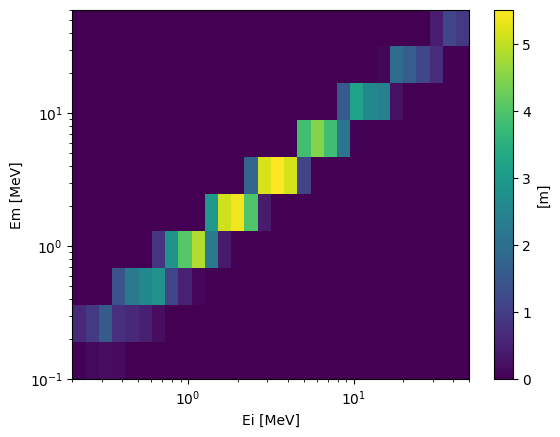

In [4]:
response.plot()

There are some tricks and corrections factor that we could use. That strategy is fine, and it can sometime works decently well under some circumstances. However, they usually have some disadvantages, for example
- Loss of sensitivity
- Statistically dubious
- They do not work in all cases
- They can introduce systematics (similarly to our 0-th order approximation)

Instead, we'll go straight to a method that always works, a likelihood-based forwards-folding analysis. 

## Maximum likelihood

Forward-folding means to always convolve or "fold" a given model to the detector response and compare the result directy to the observed data. This is opposite to "unfolding", where we start with the observed data and attempt to apply correction factor until we can approximate the underlying model.  

Forward folding involves trying many many models, trying to find the one that best describe the observed data. The one that best describes the observed data is the one that maximizes the probability of obtaining the observed data. This is called the "likelihood".

It might seem like we're saying to the same thing two different ways, so let's put it concrete terms. In our case, the observed data is the set of counts on each $E_m$ bin, let called them $N_i$. The probability of obtaining $N_k$ events when we expect $\lambda_k = N_{expected}(\Delta E_{m_k}) = \left< N_{trig}(\Delta E_{m_k}) \right>$ events is

$$P(N_k; \lambda_k) = \frac{e^{-\lambda} \lambda^{N_i}}{N_i!}$$

This is the Poisson distribution. As we explained, we use it because we assume that the event are completely independent from each other. 

As you've seen from playing with the response matrix, the expected counts depend on varios parameters, which we'll call $\mathrm{\Theta}$. We can write $\lambda_k$ as a function $\lambda_k(\mathrm{\Theta})$, where $\mathrm{\Theta}$ can be, for example, the set containing the source location, flux normalization and spectral index. Since the detector response is complicated $\lambda_k(\mathrm{\Theta})$ usually doesn't have an analytic form, but we can calculating through the dot product of the response matrix with a discretized version of a source with the parameters $\mathrm{\Theta}$.

The likelihood is then defined as

$$\mathcal{L}(N_k; \mathrm{\Theta}) = \prod P(N_k; \lambda_k(\mathrm{\Theta})) \,,$$

that is, the product of the probability for each observation given a model. This feels so intuitve that is easy to forget that the likelihood is **not** a probability distribution. It can't be normalize to one. In fact, the specific value of the likelihood function is not even important, only the *difference* between the value of the likelihood between two different set of parameters $\mathrm{\Theta}_a$ and $\mathrm{\Theta}_b$.

Since the likelihood can have very large values, and we're only care about differences in the likelihood, it's usual to work with the logarithm of the likelihood instead (the log is continously monothonic). Using the properties of the logarithm:

$$\log \mathcal{L}(N_k; \mathrm{\Theta}) = \sum_k \left[ N_k \log (\lambda_k(\mathrm{\Theta})) - \lambda_k(\mathrm{\Theta}) - \log N!\right ]$$

Finally, since $N_i!$ will be the same for any two compiting models $\mathrm{\Theta}_a$ and $\mathrm{\Theta}_b$, and it's a computationally expensive operation, we'll just get rid of it. The log-likelihood function that we'll be working with is then:

$$\log \mathcal{L}(N_k; \mathrm{\Theta}) = \sum_k \left[N_k \log (\lambda_k(\mathrm{\Theta})) - \lambda_k(\mathrm{\Theta})\right ]$$

Now, to see how this all works in practice, we'll fit again the flux and spectral index to the same data, but this time by finding the flux+index combination that maximizes the likelihood function. We'll brute-force it by computing the likelihood in a grid of flux vs index.

In [7]:
from histpy import Axis
from copy import copy, deepcopy
from tqdm import tqdm # Progress bar for the impatient

# Create and empty "histogram" (an array with labeled axes) to keep track of the log-likelihood
# \Theta in this case is the combination {flux, spectral index}
log_like = Histogram([Axis(np.geomspace(.5,2,31)/u.erg/u.cm/u.s, label = 'flux', scale = 'log'),
                      Axis(np.linspace(-3,-1,31), label = 'index')])

# Loop trough each element in the TS grid
for nflux, hyp_flux in tqdm(enumerate(log_like.axes['flux'].centers), total=log_like.axes['flux'].nbins):
    for nindex, hyp_index in enumerate(log_like.axes['index'].centers):

        # Create a hypothetical source with the flux and index combination in our grid
        # We're assuming we know the source location and therefore is kept fixed.
        source_hyp = PointSource(offaxis_angle = 0*u.deg,
                                 spectrum = PowerLawSpectrum(index = hyp_index, 
                                                             min_energy = 200*u.keV,
                                                             max_energy = 50*u.MeV),
                                 flux_pivot = hyp_flux,
                                 pivot_energy = pivot_energy)

        # Convolve the source model with the response to obtain the set of \lamda_k
        expectation = response.expected_counts(source_hyp, duration)

        # Compute the likilihood, using the equation above.
        log_like[nflux, nindex] = np.sum(data.contents*np.log(expectation.contents) - expectation.contents)

100%|██████████| 30/30 [00:33<00:00,  1.11s/it]

CPU times: user 30.7 s, sys: 340 ms, total: 31.1 s
Wall time: 33.4 s


Ok, done. Let's find the parameters that produced that maximized the likelihood and see how it looks:

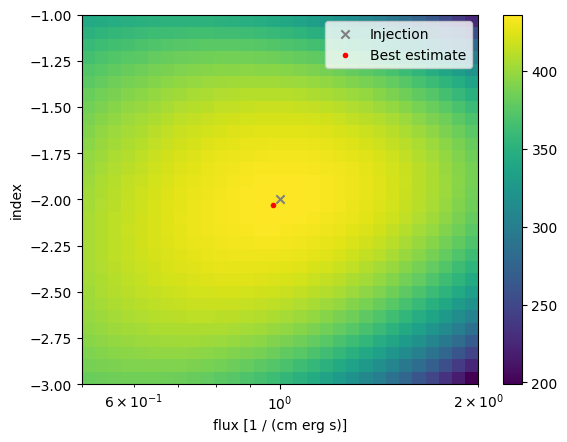

In [8]:
# Find the location of maximum likelihood
argmax_loglike = np.unravel_index(np.argmax(log_like), log_like.nbins)

flux_opt = log_like.axes[0].centers[argmax_loglike[0]] 
index_opt = log_like.axes[1].centers[argmax_loglike[1]]

# ==== Plot ====
fig,ax = plt.subplots()

# Log likelihood profile
log_like.plot(ax)

# Best and injected values
ax.scatter(flux_pivot, index, color = 'grey', marker = 'x', label = 'Injection')

ax.scatter(flux_opt, index_opt, color = 'red', marker = '.', label = 'Best estimate')

ax.legend()

Cool, as expected, the best estimate fell on top of the injection. Well, almost, it was on the neighboring bin, a penalty from discretizing the likelihood profile in a grid. If you want to make the grid finer you'll see that they we'll get closer and closer.

A measuerement however means nothing without their uncertainties. The likelihood profile looks like a big blob, but it doesn't mean that the uncertainty region covers the whole plotted window. What we need to know is how the likelihood varies from one random sample to another. In general, we can obtain the likelihood distribution by uncommenting the Poisson fluctuation line above and running this many many times. As you can imagine, this can be quite slow. Furtunately a smart guy of surname [Wilks](https://en.wikipedia.org/wiki/Wilks%27_theorem) came up with the realization that in the large sample regime, the ratio between the maximum likelihood of two different models always converge to the same distribution, independently of the case in hand. Mathematically, this is enconded in the "test statistic" (TS):

$$TS = 2 \left[\max \left(\log \mathcal{L}(\mathrm{\Theta_1})\right) - \max \left(\log \mathcal{L}(\mathrm{\Theta_0}) \right)\right] \,,$$

where $\mathrm{\Theta_0}$ and $\mathrm{\Theta_1}$ are called the null and alternative hypotheses, respectively. $\mathrm{\Theta_0}$ must have the same parameter as $\mathrm{\Theta_1}$ but with some fixed to specific values. For example, $\mathrm{\Theta_0}$ can have the index fixed to an assumed value, with only the flux let free. In fancy parlance, these are called "nested models".

When these conditions are met, then under the null hypothesis the $TS$ values are distributed as a $\chi^2$ with a number of degrees of freedom equal to the different in the number of free parameters between $\mathrm{\Theta_0}$ and $\mathrm{\Theta_0}$. 

To be honest, there are some other conditions, but only mathmaticians care about those. For practicaly purposes, just make sure that 1) $\mathrm{\Theta_1}$ and $\mathrm{\Theta_0}$ are nested model and 2) that the number of counts is not too small. If you are in the regime when you only have a few counts, *usually* the $TS$ distribution is actually not far enough from a $\chi^2$ for it to matter, but you should at lest double check this by running a few simulations.

Now, let's see this in our concrete example:

Forward-folding maximum likelihood fit
Flux  = 0.98  +0.2 0.1 [1 / (cm erg s)]
Index = -2.03 +0.2 0.2


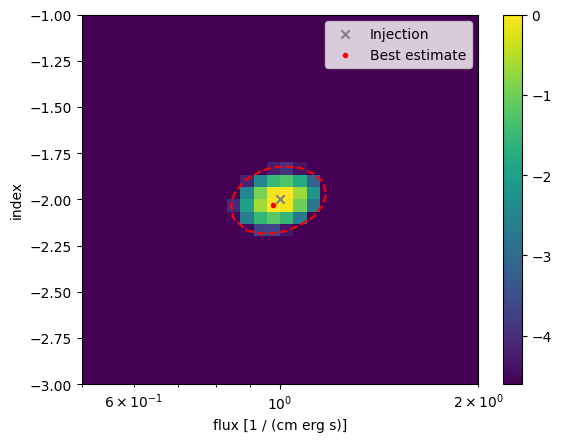

In [10]:
from scipy.stats import chi2

# For the null hypothesis we'll fix both parameter to the 
# optimal parameter we found 
log_like0 = log_like[*argmax_loglike]

# Test statistics. In this case the alternative model 
# "log_like1" is simple the same as before
ts = 2*(log_like - log_like0)

# Since we have 2 free parameter in log_like1 (flux and index)
# and none in log_like0 (we fixed both), then the TS is
# distributed as a chi2 with 2 degrees of freedom. Here we
# find the TS value that corresponds to a 90% containment
# by using the inverse of the chi2 cummulative (ppf)
uncertainty_containment = .9
contour_ts_thresh = -chi2.ppf(uncertainty_containment, df = 2)

# While the contour is not really a box, we can approximate it as such
# to be able to quote an error for each parameter. 
# If the contour does not looks very much like a horizontal or verical
# ellipse, then you should worry about correlations in your paramters
contour_idx = np.nonzero(ts >= contour_ts_thresh)
flux_upper_bound = ts.axes[0].upper_bounds[np.max(contour_idx[0])]
flux_lower_bound = ts.axes[0].lower_bounds[np.min(contour_idx[0])]
index_upper_bound = ts.axes[1].upper_bounds[np.max(contour_idx[1])]
index_lower_bound = ts.axes[1].lower_bounds[np.min(contour_idx[1])]

print("Forward-folding maximum likelihood fit")
print(f"Flux  = {flux_opt.value:.2f}  +{flux_upper_bound.value-flux_opt.value:.1f} {flux_opt.value-flux_lower_bound.value:.1f} [{flux_opt.unit}]")
print(f"Index = {index_opt:.2f} +{index_upper_bound-index_opt:.1f} {index_opt-index_lower_bound:.1f}")

# ==== Plot ====
fig,ax = plt.subplots()

# TS profile
# Limit the colorbar to the threshold contour for a niver visualization
ts.plot(ax, vmin =  contour_ts_thresh)

# Actual contour
ax.contour(ts.axes['flux'].centers,
           ts.axes['index'].centers,
           ts.contents.transpose(),
           levels = [contour_ts_thresh],
           colors = 'red')

# Best and injected values
ax.scatter(flux_pivot, index, color = 'grey', marker = 'x', label = 'Injection')

ax.scatter(flux_opt, index_opt, color = 'red', marker = '.', label = 'Best estimate')

ax.legend();

Finally, the collection of all models within our contour represent an error band in the original spectrum plot:

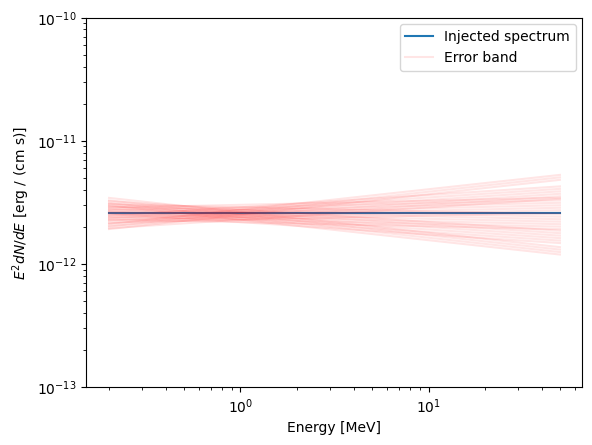

In [11]:
fig,ax = plt.subplots()

# Real spectrum
source.plot_spectrum(ax, e2 = True, label = 'Injected spectrum');

# Loop through all points in the TS grid withing the contour
for nflux,nindex in zip(*contour_idx):
     
    hyp_flux = log_like.axes['flux'].centers[nflux] 
    hyp_index = log_like.axes['index'].centers[nindex] 
        
    # Reconstruct hypothetical spectrum
    source_hyp = PointSource(offaxis_angle = 0*u.deg,
                                     spectrum = PowerLawSpectrum(index = hyp_index, 
                                                                 min_energy = 200*u.keV,
                                                                 max_energy = 50*u.MeV),
                                     flux_pivot = hyp_flux,
                                     pivot_energy = pivot_energy)

    # This is here just so the legend is legible
    label = None
    if nflux == argmax_loglike[0] and nindex == argmax_loglike[1]:
        label = "Error band"

    # Plot the spectrum corresponding to this particular model
    source_hyp.plot_spectrum(ax, e2 = True, label = label, alpha = .1, color = 'red')

ax.legend()

We used a brute-force TS grid because it is both easy to implement and to visualize. In practice though you'll might have to use a more efficient minimizer, and sample the likelihood in a smarter way. Sometimes there are so many paramters that it is even unfeasable to use a TS grid. There are many many methods to shop around that we won't cover here. For these tutorial, simply sample the TS using a relative coarse grid and try to see aproximately where the maximum is. If it looks like it's outside the window, re-adjust the axes range. Once you find something that looks like a peak, you can make the grid finer aroudn that area.

Finally, I should mention that a "maximum likelihood estimation" (MLE) as described here is just one of a large number of way to use the likelihood function. The likelihood is a pillar of modern statistical analysis, not just in frequentist approached --like MLE-- but also in Bayesian formalism. We won't cover this here either, but looks around for something that suits your problem at hand!

<div class="alert alert-block alert-info">
<b>Exercise: Fluctuations</b>
    
Uncomment the line with `np.random.poisson` a few cells above and run all cell again tul obtaining the uncertainty contour. Since we're introducing fluctuation, the value of the parameters that maximize the likelihood is not expected to be equal to the injection values. However, if we did thing correctly, the 90% containment confidence contours should, well, contain the true value 90% of the time! Run everything multiple time, each time with a different random sample, and check if this is true or how far off we are. 
</div>

<div class="alert alert-block alert-info">
<b>Exercise: Pivot energy and correlation</b>
    
The pivot energy is technically arbitrary, it's just point in the spectrum where we chose to report the spectrum normalization. Hoever, there are better options for the pivot energy than other. Repeat all of this notebook by changing the pivot energy to the edges of the detector energy range and see what happens to the TS profile and the spectrum error band. Note: since our TS grid is kinda "brute", when you change the pivot energy you'll have to adjust the flux limits such that it contains the maximum.
- Which one changes significantly and which was does not? 
- Do you see any advantage to using something closer the energy the detector is most sensitive to? 
- How does the best pivot energy looks like in the spetrum error band plot? By the way, this kind of plot for a simple power law is usually called a "bowtie" plot.
</div>

## Putting things in a box

In [109]:
class LogLikeGrid(Histogram):
    
    def __init__(self, *args, **kwargs):
        
        super().__init__(*args, **kwargs)
        
        self.ndof = self.ndim
    
    def compute(self, fun):
        
        for prod in tqdm(itertools.product(*[enumerate(a.centers) for a in self.axes]), total = np.prod(self.nbins)):
            
            idx,values = zip(*prod)
            
            self[idx] = fun(*values)
    
    def maximum(self, axis = None):
        """
        Returns either float (axis=None) or Histogram
        """
        
        if axis is None:
            return np.max(self)
        else:
            axis = tuple(np.array(self.axes.label_to_index(axis), ndmin = 1))
            
            kept_axis = tuple([a for a in range(self.ndim) if a not in axis])
        
            profile_like = LogLikeGrid([self.axes[a] for a in kept_axis],
                                       np.max(self.contents, axis = axis))
            
            # Same as the original
            profile_like.ndof = self.ndof
            
            return profile_like
        
    def max_ts(self):
        return 2*self.maximum()
    
    def get_ts_delta(self, cont = .9):
        return chi2.ppf(cont, df = self.ndof)
    
    def get_ts_thresh(self, cont = .9):
        return self.max_ts() - chi2.ppf(cont, df = self.ndof)
        
    def optimal_parameters(self):
        """
        """
        
        argmax = np.unravel_index(np.argmax(self), self.nbins)

        popt = [self.axes[i].centers[argmax[i]] for i in range(self.ndim)]
              
        if self.ndim == 1:
            return popt[0]
        else:
            return popt
        
    def contour_indices(self, cont = .9):
        
        return np.nonzero(self >= self.get_ts_thresh(cont)/2)
        
    def contour_indices_values(self, cont= .9):
        
        contour_idx = self.contour_indices(cont)
        
        return contour_idx,[([self.axes[j].centers[i] for j,i in enumerate(idx)]) for idx in zip(*contour_idx)]
        
    def parameter_bounds(self, cont = .9):
        """
        """
        
        contour_idx = self.contour_indices(cont)
        
        upper_bounds = [self.axes[i].upper_bounds[np.max(contour_idx[i])] for i in range(self.ndim)]
        lower_bounds = [self.axes[i].lower_bounds[np.min(contour_idx[i])] for i in range(self.ndim)]

        bounds = list(zip(lower_bounds, upper_bounds))
        
        if self.ndim == 1:
            return bounds[0]
        else:
            return bounds
            
    def plot_ts(self, ax = None, cont = .9, *args, **kwargs):
        
        if self.ndim > 2:
            raise RuntimeError("Can only plot 1D or 2D. Slice or profile likelihood")
        
        popt = self.optimal_parameters()
        
        max_ts = 2*self.maximum()
        
        contour_ts_delta = self.get_ts_delta(cont)
        contour_ts_thresh = max_ts - contour_ts_delta
        
        if self.ndim == 1:
            ax,_ = (2*self).plot(ax, *args, **kwargs)
            
            ax.axvline(u.Quantity(popt).value, color = 'red', label = 'Best estimate')
            
            pbounds = self.parameter_bounds(cont)
        
            ax.axvline(u.Quantity(pbounds[0]).value, color = 'red', ls = ":", label = 'Uncertainty bounds')
            ax.axvline(u.Quantity(pbounds[1]).value, color = 'red', ls = ":")
            
            ax.set_ylim(max_ts - 10*contour_ts_delta, max_ts + 3*contour_ts_delta)
        else: 
            #self.ndim == 2
            ax,_ = (2*self).plot(ax, *args, vmin = contour_ts_thresh, **kwargs)
            ax.scatter(*popt, color = 'red', label = 'Best estimate')
            ax.contour(self.axes[0].centers,
                       self.axes[1].centers,
                       2*self.contents.transpose(),
                       levels = [contour_ts_thresh],
                       colors = 'red', ls = ':')
            
        ax.legend()
        

For convenience, the code above was packaged in the LogLikeGrid class. You just need to defined the grid axes and your likelihood function and let the class do the rest!

In [87]:
from gammaraytoys.analysis import poisson_binned_log_likelihood
import itertools

# Define the axes of the grid
log_like = LogLikeGrid([Axis(np.geomspace(.5,2,20)/u.erg/u.cm/u.s, label = 'flux', scale = 'log'),
                        Axis(np.linspace(-3,-1,20), label = 'index')])


# This is the likelihood function to be evaluated on each point in the grid
# The order of the parameter must be the same as the order of the axes above.
def log_like_fun(hyp_flux, hyp_index):
    
    # Hypothetical source
    source_hyp = PointSource(offaxis_angle = 0*u.deg,
                                     spectrum = PowerLawSpectrum(index = hyp_index, 
                                                                 min_energy = 200*u.keV,
                                                             max_energy = 50*u.MeV),
                                 flux_pivot = hyp_flux,
                                 pivot_energy = pivot_energy)
    
    # Convolve the source model with the response to obtain the set of \lamda_k
    expectation = response.expected_counts(source_hyp, duration)

    # Compute the likilihood, using the equation above.
    return poisson_binned_log_likelihood(data.contents, expectation.contents)

# Loop through each point in the grid
log_like.compute(log_like_fun)

100%|██████████| 361/361 [00:13<00:00, 27.40it/s]


You can plot it as is:

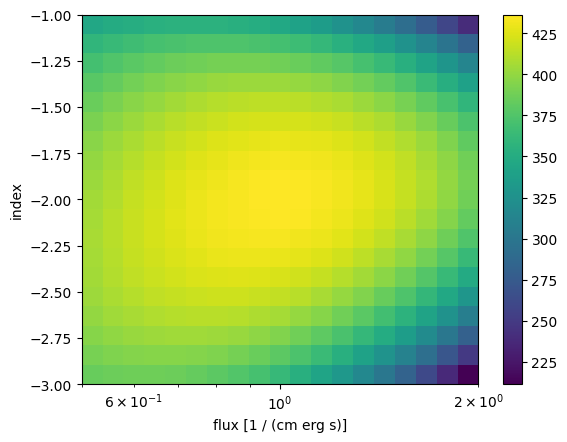

In [25]:
log_like.plot();

Or plot the TS map, including the contours:

/var/folders/5m/x6wxngsx5pz99ltky4nmln180000gp/T/ipykernel_6276/1321532717.py:112: UserWarning: The following kwargs were not used by contour: 'ls'
  ax.contour(self.axes[0].centers,


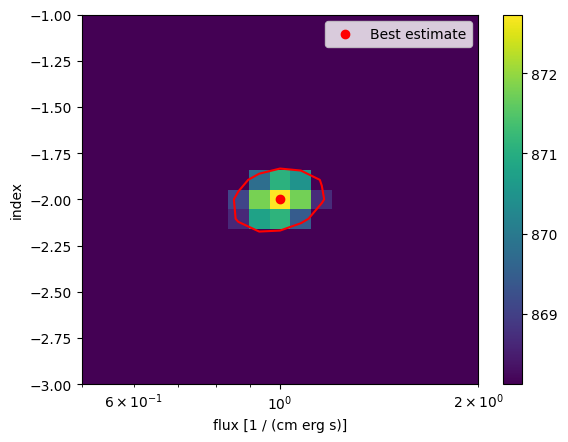

In [81]:
log_like.plot_ts(cont = .9);

You might noticed that the maximum $TS$ is not zero. That's just because we didn't specify the null hypothesis. That's fine, because we can still draw the contour based on the $Delta TS$ with respect to the maximum.

Finally, you can obtain the optima parameters and the parameter bounds:

In [88]:
popt = log_like.optimal_parameters()
pbounds = log_like.parameter_bounds(.9)

print(f"Flux best estimate = {popt[0]:.2}  Bounds = [{pbounds[0][0]:.2}, {pbounds[0][1]:.2}]")
print(f"Index best estimate = {popt[1]:.2}  Bounds = [{pbounds[1][0]:.2}, {pbounds[1][1]:.2}]")

Flux best estimate = 1.0 1 / (cm erg s)  Bounds = [0.83 1 / (cm erg s), 1.2 1 / (cm erg s)]
Index best estimate = -2.0  Bounds = [-2.2, -1.8]


## Dealing with background and other nuisance parameters, and detection significance and sensitivity

Sometimes there are certain parameters that you don't really care about, but that you need to fit in order to figure out the value of the ones you do! That's annoying! That's why they are called nuisance parameters.

For example, maybe in the example above we didn't really care about the spectral shape of the source, we just wanted to know the flux. In that case, all we have to do is to maximize the likelihood over all paraters that we don't case about. The result is usually called a "profile likelihood":

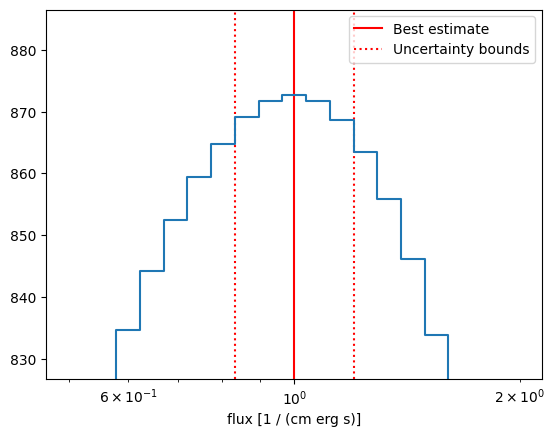

In [89]:
# The spectral index is the nuisance parameter in this case
profile_log_like_flux = log_like.maximum('index') 

profile_log_like_flux.plot_ts()

Note that the number of degrees of freedom is still 2, despite the the profile likelihood having one dimensions. We need to keep track --`LogLikeGrid` does-- of all the free parameter involve in the fit, including the nuisance parameters. Because of this, the paramter errors do not change whether you use the full or profile likelihood. You pay a price for each extra parameter!

In [92]:
print(f"Degrees of freedom = {profile_log_like_flux.ndof}")

popt_flux = profile_log_like_flux.optimal_parameters()
pbounds_flux = profile_log_like_flux.parameter_bounds(.9)

print(f"Flux best estimate = {popt_flux:.2}  Bounds = [{pbounds_flux[0]:.2}, {pbounds_flux[1]:.2}]")

Degrees of freedom = 2
Flux best estimate = 1.0 1 / (cm erg s)  Bounds = [0.83 1 / (cm erg s), 1.2 1 / (cm erg s)]


The most common nuisance paramter is the background normalization. We've been ignoring it so far, let's add it:

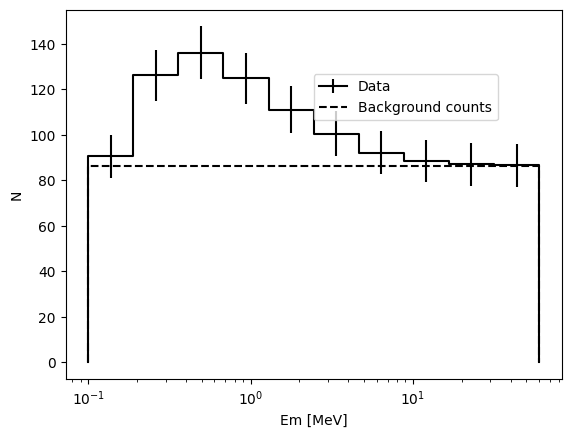

In [93]:
# Counts rom the source
signal = deepcopy(expected_signal_counts)

# Counts from background
# For simplicity, let's assume that the background is uniform
# In the real worls it is not, but no matter what shape it
# has, the rest of the calculation would be the same.
bkg_model = Histogram(signal.axis)
bkg_model[:] = 1 # "Flat" bkg. Same in all Em bins
bkg_model /= np.sum(bkg_model) # Normalize

bkg_rate = 1e-2 * u.Hz

bkg = bkg_model * (bkg_rate * duration).to_value('')

# The total data is the sum of both.
# After this point we don't which counts some from the source
# and which ones from background.
data = signal + bkg

# Uncomment to add random fluctuations
# data[:] = np.random.poisson(data.contents)

# ==== Plot ====
fig,ax = plt.subplots()

data.plot(ax, color = 'black', label = 'Data', errorbars = True)
bkg.plot(ax, color = 'black', label = 'Background counts', ls = '--')
ax.set_ylabel("N")
ax.legend(loc = (.5,.7))

Let's run our TS grid again, but this time adding the background rate as a new (annoying) parameter:

In [110]:
# Define the axes of the grid. There are 3 now
log_like = LogLikeGrid([Axis(np.geomspace(.5,2,20)/u.erg/u.cm/u.s, label = 'flux', scale = 'log'),
                        Axis(np.linspace(-3,-1,20), label = 'index'),
                        Axis(np.geomspace(.5e-2,2e-2,20)*u.Hz, label = 'bkg', scale = 'log')])


# The likelihood function now has an extra paramter as well
def log_like_fun(hyp_flux, hyp_index, hyp_bkg_rate):
    
    # Hypothetical source
    source_hyp = PointSource(offaxis_angle = 0*u.deg,
                                     spectrum = PowerLawSpectrum(index = hyp_index, 
                                                                 min_energy = 200*u.keV,
                                                             max_energy = 50*u.MeV),
                                 flux_pivot = hyp_flux,
                                 pivot_energy = pivot_energy)
    
    # Convolve the source model with the response to obtain the set of \lamda_k
    expectation = response.expected_counts(source_hyp, duration)

    # We now need to add the expectation from the background!
    # In this case we're only fitting the background *normalization*
    # and we assume that we now the background distribution
    # In the following tutorial we'll see some examples on how to estimate it
    expectation += bkg_model * (hyp_bkg_rate * duration).to_value('')
    
    # Compute the likilihood, using the equation above.
    return poisson_binned_log_likelihood(data.contents, expectation.contents)

# Loop through each point in the grid
log_like.compute(log_like_fun)

100%|██████████| 6859/6859 [04:18<00:00, 26.57it/s]


Now, we maximize along the background rate to "remove" this nuisance, and obtain the profile likelihood for the flux normalization and the spectral index.

/var/folders/5m/x6wxngsx5pz99ltky4nmln180000gp/T/ipykernel_6276/3922477779.py:112: UserWarning: The following kwargs were not used by contour: 'ls'
  ax.contour(self.axes[0].centers,


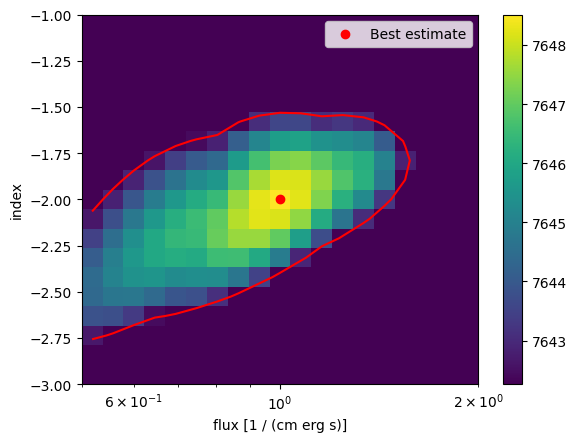

In [111]:
profile_log_like = log_like.maximum('bkg') 

profile_log_like.plot_ts()

Here you can see that even though the best estimate for the flux and spectral index remain the same, the uncertainty increased signitifantly, just as what you would expect from having background

Event though what matters is not $TS$ but $Delta TS$, we can give a meaning to the $TS$ values by providing a sensible null hypothesis. A typicall null hypothesis is the background-only hypothesis. That is, that there is not source, for which we fix the flux to 0. If the flux=0 then the spectral index has no meaning. Therefore we will be fitting only the background normalization

In [112]:
log_like0 = LogLikeGrid(Axis(np.geomspace(.5e-2,2e-2,20)*u.Hz, label = 'bkg', scale = 'log'))

log_like_fun0 = lambda hyp_bkg_rate: log_like_fun(hyp_flux = 0/u.cm/u.s/u.erg, hyp_index = 0, hyp_bkg_rate = hyp_bkg_rate)

log_like0.compute(log_like_fun0)

100%|██████████| 19/19 [00:00<00:00, 379.71it/s]


The null hypothesis fits the data assuming it's all background. In this particular case, since the background is uniform, the bkg rate fit must converge to the total data rate.

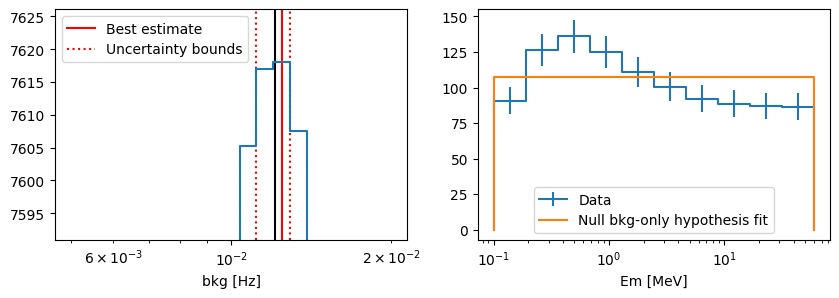

In [121]:
fig,axes = plt.subplots(figsize = [10,3], ncols = 2)

# --- TS map ----
ax = axes[0]
log_like0.plot_ts(ax)

# Data rate
ax.axvline((np.sum(data)/duration).to_value(u.Hz), color = 'black')

# --- Bkg-only model in data space ---
bkg_rate_opt0 = log_like0.optimal_parameters()

# Data
ax = axes[1]
data.plot(ax, errorbars = True, label = "Data")

# Best fit
null_hyp_data_fit = bkg_model * (bkg_rate_opt0 * duration).to_value('')
null_hyp_data_fit.plot(ax, label = "Null bkg-only hypothesis best fit")

ax.legend()

Using this we can compute a new $TS$ by comparing the alternative (source) and null (bkg-only) hypthesis:

In [136]:
ts_detection = 2*(log_like.maximum() - log_like0.maximum())
print(ts_detection)

30.541203001971553


Thanks to Wilks we know how $TS$ is randomly distributed under the background-only hyothesis:a $\chi^2$ with a number of degrees of freedom equal to the difference in free parameters between the alternative and null hypothesis. Therefore, we can compute a p-value! A p-value is precisely defined as the probability, under the null hypothesis, of obtaining a result (the $TS$ in our case) equal or more extreme that what we observed. We can use the survival function to compute this number:

In [144]:
pvalue = chi2.sf(ts_detection, df = log_like.ndof - log_like0.ndof)
print(pvalue)

2.3337913873199352e-07


It's common report the significance in "sigmas" instead of a p-value. This is just the value of a normal distribution, in multiple of the width $\sigma$, that has the same survival value as the p-value. That is

In [146]:
from scipy.stats import norm

significance = norm.isf(pvalue)

print(significance)

5.039496453764761


That is, this is a $5\sigma$ detection!

This procedure is called a [likelihood ratio test](https://en.wikipedia.org/wiki/Likelihood-ratio_test) (the logarithm of the ratio of two likelihood is the difference between their logarithms). Is a very very powerfull way to distinguish between two competing models, in this case the precense of a source vs. on background. In fact, the [Neyman-Pearson_lemma](https://en.wikipedia.org/wiki/Neyman%E2%80%93Pearson_lemma) tell us that is is _the_ most powerfull test _if_ the alternative model is correct. And well, some other not very practical details that only mathematicians care about.
 
When the difference in degrees of freedom is 1, then the significance is simply $\sqrt{TS}$. This is because the square of a normally distributed variable is distributed as a $\chi^2_{ndof = 1}$. This is why you can approximate the significance as $\sigma \approx (N_{data} - N_{bkg})/\sqrt{N_{data}}$ in the small-signal large-background regime. In our case:

In [154]:
# BoTE = back of the envelope
significance_bote = np.sum(data - bkg)/np.sqrt(np.sum(data))
print(significance_bote)

5.575082895136235


The above is not exactly right, of course, but it's not bad for a quick back of the envelop calculation!

<div class="alert alert-block alert-info">
<b>Exercise: Sensitivity calculation </b>
    
The sensitivity of an instrument can be defined as a flux that would result on a e.g. $5\sigma$ detection on average. The sensitivity can be estimated by varying the flux until the likelihood ratio test results in $5\sigma$. To compute the "continuum" sensitivity, we usually restrict the min/max energy of the spectrum of a test source to a relatively narrow energy range e.g. a quarter decade. 
    
- Go back to one of the first cells in this notebook and change the min-max range to 1 MeV to 1.778 MeV (a quarter decade) and change the pivot energy to 1.333 MeV (the log center of the quarter decade bin).
- Compute the detection significance, using a hypothetical source with the same energy range. You don't have to compute the whole (flux,index,bkg) grid. Since we're estimating the _average_ significance, you can evaluate the likelihood at the known input (flux,index,bkg) values. You do need to evaluate the log_like0, which is fast, since the data is not bkg-only. 
- Vary the flux until you obtain approximate $5\sigma$. You can do this using a bisection method. This is the sensitivity for this energy range
- If you are extra motivated, repeat this operation for multiple half decades to get the continuum sensitivity as a function of the energy.
</div>